In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.utils import spectral_norm
import librosa
import os
import librosa.display
from IPython.display import Audio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import copy
from scipy import signal
from tqdm import tqdm
import soundfile as sf

In [2]:
SAMPLE_RATE = 16000
FRAME_SHIFT = 0.0125
FRAME_LENGTH = 0.05
TOP_DB = 15
PREEMHPASIS = 0.97
N_FFT = 2048
HOP_LENGTH = int(SAMPLE_RATE*FRAME_SHIFT)
WIN_LENTGH = int(SAMPLE_RATE*FRAME_LENGTH)
N_MELS = 512
REF_DB = 20
MAX_DB = 100
N_GRIFFIN_LIM_ITER = 100
FRAME_SIZE = 1

In [3]:
def get_spectrograms(fpath):
    y, sr = librosa.load(fpath, sr=SAMPLE_RATE)
    y, _ = librosa.effects.trim(y, top_db=TOP_DB)
    y = np.append(y[0], y[1:] - PREEMHPASIS * y[:-1])
    # stft
    linear = librosa.stft(y=y,
                          n_fft=N_FFT,
                          hop_length=HOP_LENGTH,
                          win_length=WIN_LENTGH)

    mag = np.abs(linear)
    # mel spectrogram
    mel_basis = librosa.filters.mel(sr=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)
    mel = np.dot(mel_basis, mag)

    # to decibel
    mel = 20 * np.log10(np.maximum(1e-5, mel))

    # normalize
    mel = np.clip((mel - REF_DB + MAX_DB) / MAX_DB, 1e-8, 1)

    # Transpose
    mel = mel.T.astype(np.float32)

    return mel, y

In [12]:
def invert_spectrogram(spectrogram):
    '''
    spectrogram: [f, t]
    '''
    return librosa.istft(spectrogram, hop_length = HOP_LENGTH, win_length=WIN_LENTGH, window="hann")

def griffin_lim(spectrogram):
    X_best = copy.deepcopy(spectrogram)
    for i in range(N_GRIFFIN_LIM_ITER):
        X_t = invert_spectrogram(X_best)
        est = librosa.stft(X_t, n_fft = N_FFT, hop_length = HOP_LENGTH, win_length = WIN_LENTGH)
        phase = est / np.maximum(1e-8, np.abs(est))
        X_best = spectrogram * phase
    X_t = invert_spectrogram(X_best)
    y = np.real(X_t)
    return y

def _mel_to_linear_matrix(sr, n_fft, n_mels):
    m = librosa.filters.mel(sr = sr, n_fft = n_fft,n_mels = n_mels)
    m_t = np.transpose(m)
    p = np.matmul(m, m_t)
    d = [1.0 / x if np.abs(x) > 1.0e-8 else x for x in np.sum(p, axis=0)]
    return np.matmul(m_t, np.diag(d))

def melspectrogram2wav(mel):
    mel = mel.T
    # de-noramlize
    mel = (np.clip(mel, 0, 1) * MAX_DB) - MAX_DB + REF_DB

    # to amplitude
    mel = np.power(10.0, mel * 0.05)
    m = _mel_to_linear_matrix(SAMPLE_RATE, N_FFT, N_MELS)
    mag = np.dot(m, mel)
    # wav reconstruction
    wav = griffin_lim(mag)
    # de-preemphasis
    wav = signal.lfilter([1], [1, -PREEMHPASIS], wav)
    # trim
    wav, _ = librosa.effects.trim(wav)
    return wav.astype(np.float32)

def load_model(model, weigths_path):
    model.load_state_dict(torch.load(weigths_path))
    return model

In [5]:
config = {
    "SpeakerEncoder": {
        "c_in": 512,
        "c_h": 128,
        "c_out": 128,
        "kernel_size": 5,
        "bank_size": 8,
        "bank_scale": 1,
        "c_bank": 128,
        "n_conv_blocks": 6,
        "n_dense_blocks": 6,
        "subsample": [
            1,
            2,
            1,
            2,
            1,
            2
        ],
        "act": "relu",
        "dropout_rate": 0
    },
    "ContentEncoder": {
        "c_in": 512,
        "c_h": 128,
        "c_out": 128,
        "kernel_size": 5,
        "bank_size": 8,
        "bank_scale": 1,
        "c_bank": 128,
        "n_conv_blocks": 6,
        "subsample": [
            1,
            2,
            1,
            2,
            1,
            2
        ],
        "act": "relu",
        "dropout_rate": 0
    },
    "Decoder": {
        "c_in": 128,
        "c_cond": 128,
        "c_h": 128,
        "c_out": 512,
        "kernel_size": 5,
        "n_conv_blocks": 6,
        "upsample": [
            2,
            1,
            2,
            1,
            2,
            1
        ],
        "act": "relu",
        "sn": False,
        "dropout_rate": 0
    },
    "optimizer": {
        "lr": 0.0005,
        "beta1": 0.9,
        "beta2": 0.999,
        "amsgrad": True,
        "weight_decay": 0.0001,
        "grad_norm": 5
    },
    "lambda": {
        "lambda_rec": 10,
        "lambda_kl": 1
    },
    "data_loader" : {
        "batch_size" : 128
    },
    "annealing_iters": 20000,
    "dataset_path" : "spk_data",
    "n_iterations" : 20000,
    "save_frequency" : 1000,
}

In [13]:
def pad_layer(inp, layer, pad_type='reflect'):
    kernel_size = layer.kernel_size[0]
    if kernel_size % 2 == 0:
        pad = (kernel_size//2, kernel_size//2 - 1)
    else:
        pad = (kernel_size//2, kernel_size//2)
    # padding
    inp = F.pad(inp, 
            pad=pad,
            mode=pad_type)
    out = layer(inp)
    return out

def pad_layer_2d(inp, layer, pad_type='reflect'):
    kernel_size = layer.kernel_size
    if kernel_size[0] % 2 == 0:
        pad_lr = [kernel_size[0]//2, kernel_size[0]//2 - 1]
    else:
        pad_lr = [kernel_size[0]//2, kernel_size[0]//2]
    if kernel_size[1] % 2 == 0:
        pad_ud = [kernel_size[1]//2, kernel_size[1]//2 - 1]
    else:
        pad_ud = [kernel_size[1]//2, kernel_size[1]//2]
    pad = tuple(pad_lr + pad_ud)
    # padding
    inp = F.pad(inp, 
            pad=pad,
            mode=pad_type)
    out = layer(inp)
    return out

def pixel_shuffle_1d(inp, scale_factor=2):
    batch_size, channels, in_width = inp.size()
    channels //= scale_factor
    out_width = in_width * scale_factor
    inp_view = inp.contiguous().view(batch_size, channels, scale_factor, in_width)
    shuffle_out = inp_view.permute(0, 1, 3, 2).contiguous()
    shuffle_out = shuffle_out.view(batch_size, channels, out_width)
    return shuffle_out

def upsample(x, scale_factor=2):
    x_up = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
    return x_up

def flatten(x):
    out = x.contiguous().view(x.size(0), x.size(1) * x.size(2))
    return out

def concat_cond(x, cond):
    # x = [batch_size, x_channels, length]
    # cond = [batch_size, c_channels]
    cond = cond.unsqueeze(dim=2)
    cond = cond.expand(*cond.size()[:-1], x.size(-1))
    out = torch.cat([x, cond], dim=1)
    return out

def append_cond(x, cond):
    # x = [batch_size, x_channels, length]
    # cond = [batch_size, x_channels * 2]
    p = cond.size(1) // 2
    mean, std = cond[:, :p], cond[:, p:]
    out = x * std.unsqueeze(dim=2) + mean.unsqueeze(dim=2)
    return out

def conv_bank(x, module_list, act, pad_type='reflect'):
    outs = []
    for layer in module_list:
        out = act(pad_layer(x, layer, pad_type))
        outs.append(out)
    out = torch.cat(outs + [x], dim=1)
    return out

def get_act(act):
    if act == 'relu':
        return nn.ReLU()
    elif act == 'lrelu':
        return nn.LeakyReLU()
    else:
        return nn.ReLU()

class SpeakerEncoder(nn.Module):
    def __init__(self, c_in, c_h, c_out, kernel_size,
            bank_size, bank_scale, c_bank, 
            n_conv_blocks, n_dense_blocks, 
            subsample, act, dropout_rate):
        super(SpeakerEncoder, self).__init__()
        self.c_in = c_in
        self.c_h = c_h
        self.c_out = c_out
        self.kernel_size = kernel_size
        self.n_conv_blocks = n_conv_blocks
        self.n_dense_blocks = n_dense_blocks
        self.subsample = subsample
        self.act = get_act(act)
        self.conv_bank = nn.ModuleList(
                [nn.Conv1d(c_in, c_bank, kernel_size=k) for k in range(bank_scale, bank_size + 1, bank_scale)])
        in_channels = c_bank * (bank_size // bank_scale) + c_in
        self.in_conv_layer = nn.Conv1d(in_channels, c_h, kernel_size=1)
        self.first_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size) for _ \
                in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size, stride=sub) 
            for sub, _ in zip(subsample, range(n_conv_blocks))])
        self.pooling_layer = nn.AdaptiveAvgPool1d(1)
        self.first_dense_layers = nn.ModuleList([nn.Linear(c_h, c_h) for _ in range(n_dense_blocks)])
        self.second_dense_layers = nn.ModuleList([nn.Linear(c_h, c_h) for _ in range(n_dense_blocks)])
        self.output_layer = nn.Linear(c_h, c_out)
        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def conv_blocks(self, inp):
        out = inp
        # convolution blocks
        for l in range(self.n_conv_blocks):
            y = pad_layer(out, self.first_conv_layers[l])
            y = self.act(y)
            y = self.dropout_layer(y)
            y = pad_layer(y, self.second_conv_layers[l])
            y = self.act(y)
            y = self.dropout_layer(y)
            if self.subsample[l] > 1:
                out = F.avg_pool1d(out, kernel_size=self.subsample[l], ceil_mode=True)
            out = y + out
        return out

    def dense_blocks(self, inp):
        out = inp
        # dense layers
        for l in range(self.n_dense_blocks):
            y = self.first_dense_layers[l](out)
            y = self.act(y)
            y = self.dropout_layer(y)
            y = self.second_dense_layers[l](y)
            y = self.act(y)
            y = self.dropout_layer(y)
            out = y + out
        return out

    def forward(self, x):
        out = conv_bank(x, self.conv_bank, act=self.act)
        out = pad_layer(out, self.in_conv_layer)
        out = self.act(out)
        # conv blocks
        out = self.conv_blocks(out)
        out = self.pooling_layer(out).squeeze(2)
        out = self.dense_blocks(out)
        out = self.output_layer(out)
        return out

class ContentEncoder(nn.Module):
    def __init__(self, c_in, c_h, c_out, kernel_size,
            bank_size, bank_scale, c_bank, 
            n_conv_blocks, subsample, 
            act, dropout_rate):
        super(ContentEncoder, self).__init__()
        self.n_conv_blocks = n_conv_blocks
        self.subsample = subsample
        self.act = get_act(act)
        self.conv_bank = nn.ModuleList(
                [nn.Conv1d(c_in, c_bank, kernel_size=k) for k in range(bank_scale, bank_size + 1, bank_scale)])
        in_channels = c_bank * (bank_size // bank_scale) + c_in
        self.in_conv_layer = nn.Conv1d(in_channels, c_h, kernel_size=1)
        self.first_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size) for _ \
                in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size, stride=sub) 
            for sub, _ in zip(subsample, range(n_conv_blocks))])
        self.norm_layer = nn.InstanceNorm1d(c_h, affine=False)
        self.mean_layer = nn.Conv1d(c_h, c_out, kernel_size=1)
        self.std_layer = nn.Conv1d(c_h, c_out, kernel_size=1)
        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        out = conv_bank(x, self.conv_bank, act=self.act)
        # dimension reduction layer
        out = pad_layer(out, self.in_conv_layer)
        out = self.norm_layer(out)
        out = self.act(out)
        out = self.dropout_layer(out)
        # convolution blocks
        for l in range(self.n_conv_blocks):
            y = pad_layer(out, self.first_conv_layers[l])
            y = self.norm_layer(y)
            y = self.act(y)
            y = self.dropout_layer(y)
            y = pad_layer(y, self.second_conv_layers[l])
            y = self.norm_layer(y)
            y = self.act(y)
            y = self.dropout_layer(y)
            if self.subsample[l] > 1:
                out = F.avg_pool1d(out, kernel_size=self.subsample[l], ceil_mode=True)
            out = y + out
        mu = pad_layer(out, self.mean_layer)
        log_sigma = pad_layer(out, self.std_layer)
        return mu, log_sigma

class Decoder(nn.Module):
    def __init__(self, 
            c_in, c_cond, c_h, c_out, 
            kernel_size,
            n_conv_blocks, upsample, act, sn, dropout_rate):
        super(Decoder, self).__init__()
        self.n_conv_blocks = n_conv_blocks
        self.upsample = upsample
        self.act = get_act(act)
        f = spectral_norm if sn else lambda x: x
        self.in_conv_layer = f(nn.Conv1d(c_in, c_h, kernel_size=1))
        self.first_conv_layers = nn.ModuleList([f(nn.Conv1d(c_h, c_h, kernel_size=kernel_size)) for _ \
                in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList(\
                [f(nn.Conv1d(c_h, c_h * up, kernel_size=kernel_size)) \
                for _, up in zip(range(n_conv_blocks), self.upsample)])
        self.norm_layer = nn.InstanceNorm1d(c_h, affine=False)
        self.conv_affine_layers = nn.ModuleList(
                [f(nn.Linear(c_cond, c_h * 2)) for _ in range(n_conv_blocks*2)])
        self.out_conv_layer = f(nn.Conv1d(c_h, c_out, kernel_size=1))
        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def forward(self, z, cond):
        out = pad_layer(z, self.in_conv_layer)
        out = self.norm_layer(out)
        out = self.act(out)
        out = self.dropout_layer(out)
        # convolution blocks
        for l in range(self.n_conv_blocks):
            y = pad_layer(out, self.first_conv_layers[l])
            y = self.norm_layer(y)
            y = append_cond(y, self.conv_affine_layers[l*2](cond))
            y = self.act(y)
            y = self.dropout_layer(y)
            y = pad_layer(y, self.second_conv_layers[l])
            if self.upsample[l] > 1:
                y = pixel_shuffle_1d(y, scale_factor=self.upsample[l])
            y = self.norm_layer(y)
            y = append_cond(y, self.conv_affine_layers[l*2+1](cond))
            y = self.act(y)
            y = self.dropout_layer(y)
            if self.upsample[l] > 1:
                out = y + upsample(out, scale_factor=self.upsample[l]) 
            else:
                out = y + out
        out = pad_layer(out, self.out_conv_layer)
        return out

class AE(nn.Module):
    def __init__(self, config):
        super(AE, self).__init__()
        self.speaker_encoder = SpeakerEncoder(**config['SpeakerEncoder'])
        self.content_encoder = ContentEncoder(**config['ContentEncoder'])
        self.decoder = Decoder(**config['Decoder'])

    def forward(self, x):
        emb = self.speaker_encoder(x)
        mu, log_sigma = self.content_encoder(x)
        eps = log_sigma.new(*log_sigma.size()).normal_(0, 1)
        dec = self.decoder(mu + torch.exp(log_sigma / 2) * eps, emb)
        return mu, log_sigma, emb, dec

    def inference(self, x, x_cond):
        emb = self.speaker_encoder(x_cond)
        mu, _ = self.content_encoder(x)
        dec = self.decoder(mu, emb)
        return dec

    def get_speaker_embeddings(self, x):
        emb = self.speaker_encoder(x)
        return emb

In [14]:
# model test
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = AE(config).to(DEVICE)

In [15]:
test = torch.rand((1, 512, 209)).to(DEVICE)
res = model.inference(test, test)
print(res.shape)

torch.Size([1, 512, 216])


mel shape (231, 512)


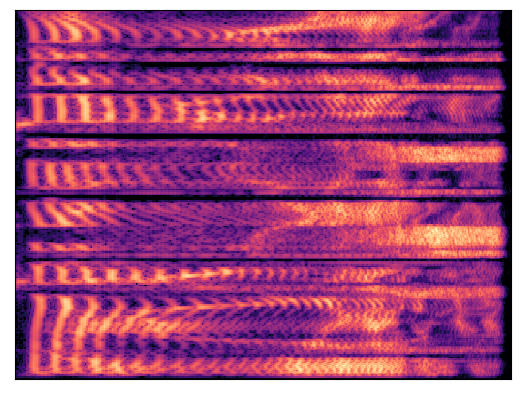

In [16]:
# voice test
voice_path = os.path.join(os.getcwd(),"..", "spk_data", "speaker2", "arctic_a0007.wav")
mel, _ = get_spectrograms(voice_path)
librosa.display.specshow(mel)
print(f"mel shape {mel.shape}")

In [17]:
voice_again = melspectrogram2wav(mel)
Audio(voice_again, rate = SAMPLE_RATE)

Test loaded model from weights

In [18]:
MODEL_PATH = os.path.join("..", "models", "model_save_iter_59999.ckpt")
model = AE(config).to(DEVICE)
model = load_model(model, MODEL_PATH)

In [19]:
voice_1 = os.path.join("..", "spk_data", "speaker2", "arctic_a0007.wav")
voice_2 = os.path.join("..", "spk_data", "speaker3", "arctic_a0008.wav")

voice_1, _ = get_spectrograms(voice_1)
voice_2, _ = get_spectrograms(voice_2)

In [20]:
mean = np.mean(np.vstack([voice_1, voice_2]))
std = np.std(np.vstack([voice_1, voice_2]))

In [21]:
normalized_voice1 = (voice_1 - mean) / std
normalized_voice2 = (voice_2 - mean) / std

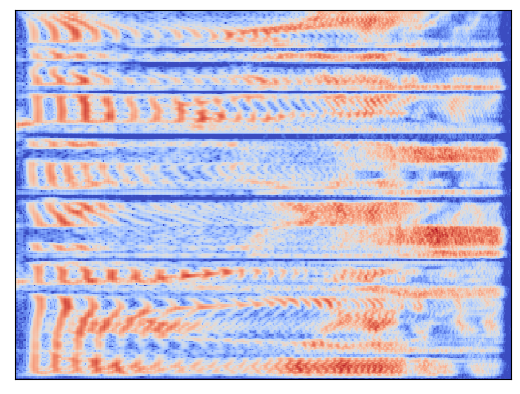

In [22]:
librosa.display.specshow(normalized_voice1)

In [23]:
normalized_voice1 = torch.from_numpy(normalized_voice1).to(DEVICE)
normalized_voice2 = torch.from_numpy(normalized_voice2).to(DEVICE)

In [24]:
with torch.no_grad():
    men_to_fem = model.inference(normalized_voice1.T.unsqueeze(0), normalized_voice2.T.unsqueeze(0))
    fem_to_men = model.inference(normalized_voice2.T.unsqueeze(0), normalized_voice1.T.unsqueeze(0))

In [25]:
with torch.no_grad():
    _, _, _, dec1 = model(normalized_voice1.T.unsqueeze(0))
    _, _, _, dec2 = model(normalized_voice2.T.unsqueeze(0))

In [26]:
men_to_fem = (men_to_fem.squeeze(0).cpu().numpy().T * std) + mean
fem_to_men = (fem_to_men.squeeze(0).cpu().numpy().T * std) + mean
print(men_to_fem.shape, fem_to_men.shape)

(232, 512) (184, 512)


In [27]:
decoded1 = (dec1.squeeze(0).cpu().numpy().T * std) + mean
decoded2 = (dec2.squeeze(0).cpu().numpy().T * std) + mean

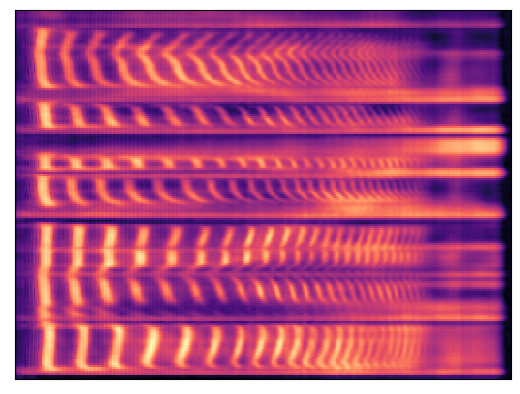

In [28]:
librosa.display.specshow(decoded2)

In [29]:
men_to_fem = melspectrogram2wav(men_to_fem)
Audio(men_to_fem, rate = SAMPLE_RATE)

In [30]:
fem_to_men = melspectrogram2wav(fem_to_men)
Audio(fem_to_men, rate = SAMPLE_RATE)

In [39]:
source_speaker = "speaker2"
target_speaker = "speaker3"
source_sample = "arctic_a0011.wav"
target_sample = "arctic_a0011.wav"

DATA_PATH = os.path.join("..", "spk_data")
SOURCE_SPEECH = os.path.join(DATA_PATH, source_speaker, source_sample)
TARGET_SPEECH = os.path.join(DATA_PATH, target_speaker, target_sample)

CONVERSION_PATH = os.path.join("..", "models", "vae-inception", "conversions")
SRC_TARGET_CONVERSION = os.path.join(CONVERSION_PATH, f"{source_speaker}_{target_speaker}_{source_sample}")
TARGET_SRC_CONVERSION = os.path.join(CONVERSION_PATH, f"{target_speaker}_{source_speaker}_{target_sample}")

# voice preparation
source_mel, source_speech = get_spectrograms(SOURCE_SPEECH)
target_mel, target_speech = get_spectrograms(TARGET_SPEECH)
#
mean = np.mean(np.vstack([source_mel, target_mel]))
std = np.std(np.vstack([source_mel, target_mel]))
# normalize
source_mel = (source_mel - mean) / std
target_mel = (target_mel - mean) / std

source_mel, target_mel = torch.from_numpy(source_mel).to(DEVICE), torch.from_numpy(target_mel).to(DEVICE)

with torch.no_grad():
    source_target = model.inference(source_mel.T.unsqueeze(0), target_mel.T.unsqueeze(0))
    target_source = model.inference(target_mel.T.unsqueeze(0), source_mel.T.unsqueeze(0))

source_target = (source_target.squeeze(0).cpu().numpy().T * std) + mean
target_source = (target_source.squeeze(0).cpu().numpy().T * std) + mean

source_target = melspectrogram2wav(source_target)
target_source = melspectrogram2wav(target_source)

Audio(np.hstack([source_target, np.zeros(20),  target_speech]), rate = SAMPLE_RATE)

In [40]:
Audio(np.hstack([target_source, np.zeros(20), source_speech]), rate = SAMPLE_RATE)

In [31]:
# sf.write("converted_data/variational-autoencoder-vc/fem_to_men.wav", fem_to_men, SAMPLE_RATE)